In [1]:
import numpy as np
import generative_model, generative_model_global
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import copy
from tqdm.notebook import tqdm

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sys, os
sys.path.append(os.path.dirname(sys.path[0]))

from discrepancies import datasets, pool, pool2graph, elephant_evaluation, discrepancies_intervals, DNN_pool, fair_helpers



ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

In [3]:
import dill
#dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')

# Example of Fair classifier (with DNN)

In [ ]:


X_train, X_test, y_train, y_test, scaler, feature_names, target_names = datasets.get_dataset(dataset='boston')
sensitive_name = 'B'

Z_train, Z_test = X_train[sensitive_name], X_test[sensitive_name]
del X_train[sensitive_name]
del X_test[sensitive_name]
feature_names = [f for f in feature_names if f != sensitive_name]

print(feature_names)

### Training one Clf: example

100%|██████████| 200/200 [00:05<00:00, 38.98it/s]


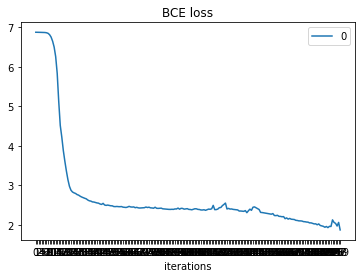

Clf accuracy on test 0.8922155688622755


In [5]:
clf = DNN_pool.Classifier(n_features=X_train.shape[1],
                n_hlayers=10,
                n_hidden=10)
clf.fit(X_train, y_train, n_epochs=200, plot=True)


print("Clf accuracy on test", (clf.predict(X_test) == y_test).mean())

### Training a fair classifier using clf

Not clear if clf should be trained alone, if clf and adv should be pretrained, or none of the above.

100%|██████████| 100/100 [00:01<00:00, 73.12it/s]


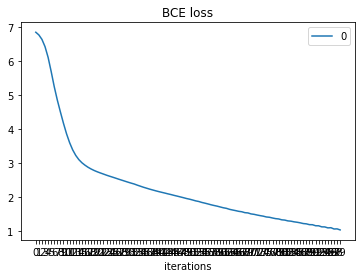

100%|██████████| 100/100 [00:02<00:00, 42.76it/s]


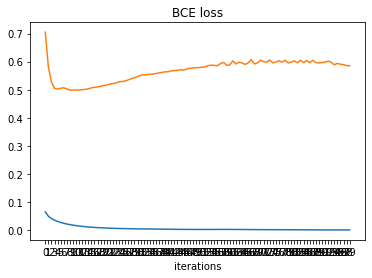

Adversarial MSE 1.0932346664796289
Clf accuracy fair 0.8922155688622755


In [4]:
clf = DNN_pool.Classifier(n_features=X_train.shape[1],
                n_hlayers=3,
                n_hidden=20)
clf.fit(X_train, y_train, n_epochs=100, plot=True)

# fair._pretrain_both(X_train, Z_train, y_train)



fair = DNN_pool.FairZhang(clf, lambda_=1.0)
fair.fit(X_train, Z_train, y_train, plot=True, n_epochs=100)
print("Adversarial MSE", (((fair.predict_sensitive_adv(X_test).flatten() - Z_test))**2).mean())
print("Clf accuracy fair", (fair.clf.predict(X_test) == y_test).mean())


### Comparing a fair and a biased classifier: sandbox

In [46]:
clf_biased = DNN_pool.Classifier(n_features=X_train.shape[1],
                n_hlayers=5,
                n_hidden=30)
clf_biased.fit(X_train, y_train, n_epochs=100, plot=False)

clf_dummy = DNN_pool.Classifier(n_features=X_train.shape[1], n_hlayers=5, n_hidden=30)
clf_fair = DNN_pool.FairZhang(clf_dummy, lambda_=1.0)
clf_fair.pretrain_both(X_train, Z_train, y_train)
clf_fair.fit(X_train, Z_train, y_train, plot=False, n_epochs=100)
print("Adversarial MSE", (((clf_fair.predict_sensitive_adv(X_test).flatten() - Z_test))**2).mean())
print("Clf accuracy fair", (clf_fair.clf.predict(X_test) == y_test).mean())
print("Clf accuracy biased", (clf_biased.predict(X_test) == y_test).mean())


100%|██████████| 100/100 [00:02<00:00, 42.05it/s]


Adversarial MSE 1.0848691709424065
Clf accuracy fair 0.8802395209580839
Clf accuracy biased 0.9041916167664671


# Discrepancy analysis with p2g

In [61]:
%%time

pool1 = DNN_pool.ZhangPool()
pool1.fit(X_train, Z_train, y_train, n_epochs=100)

p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=20)
p2g.fit(max_epochs=5)



100%|██████████| 100/100 [00:02<00:00, 42.04it/s]
### EPOCH #1
### EPOCH #2
### EPOCH #3
### EPOCH #4
### EPOCH #5


CPU times: user 5.63 s, sys: 33 ms, total: 5.67 s
Wall time: 5.67 s


In [62]:
from sklearn.metrics import confusion_matrix


pd.DataFrame(confusion_matrix(pool1.predict(X_test).iloc[:, 0], pool1.predict(X_test).iloc[:, 1]), columns=['fair 0', 'fair 1'])



,fair 0,fair 1
0,45,17
1,2,103


In [63]:
intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
len(intervals)

3002

In [64]:
global_interval_coord = []
for di in intervals:
    interval_coord = np.array((di.border_features.iloc[0] - di.border_features.iloc[1]).abs())
    global_interval_coord.append(interval_coord)
global_interval_coord = np.array(global_interval_coord)
global_interval_coord = pd.DataFrame(global_interval_coord, columns = X_train.columns)

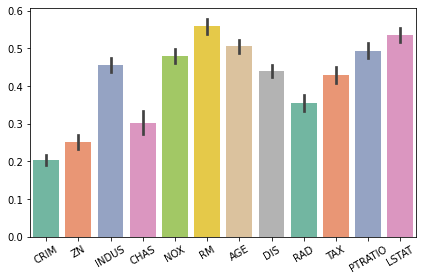

In [66]:
sns.set_style()


ax = sns.barplot(data=global_interval_coord, ci=95, palette="Set2")
ax.set_xticklabels(X_train.columns,rotation=30)

plt.tight_layout()

         CRIM   ZN  INDUS  CHAS  NOX   RM  AGE  DIS  RAD  TAX  PTRATIO  LSTAT
cluster                                                                      
0         117  117    117   117  117  117  117  117  117  117      117    117
1         241  241    241   241  241  241  241  241  241  241      241    241
2         120  120    120   120  120  120  120  120  120  120      120    120
3         116  116    116   116  116  116  116  116  116  116      116    116
4         215  215    215   215  215  215  215  215  215  215      215    215


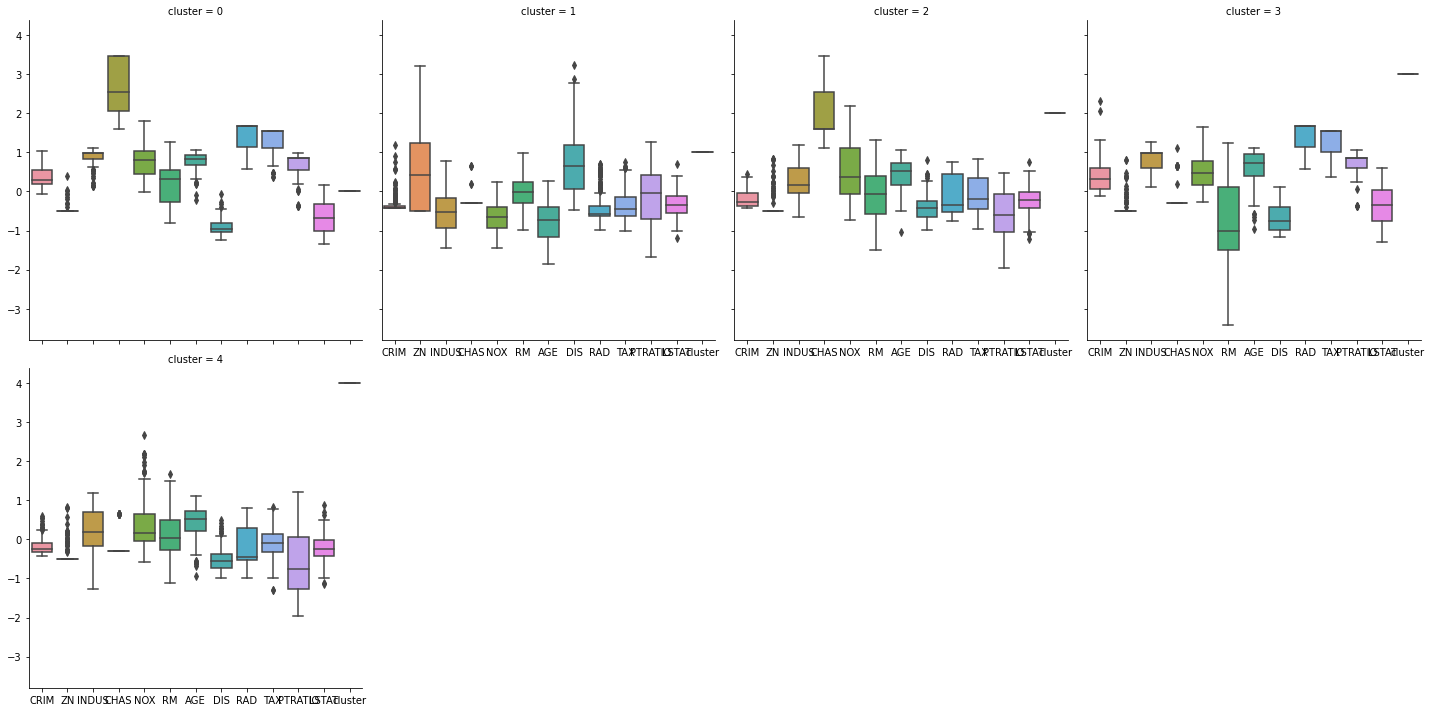

In [74]:
from sklearn.cluster import KMeans

oneborder = np.array([di.border_features.iloc[0] for di in intervals])
coord_intervals = []
for di in intervals:
    a, b = di.border_features.iloc[0], di.border_features.iloc[1]
    if a[0] > 0:
        interval_coord = a - b
    else:
        interval_coord = a - b
    coord_intervals.append(interval_coord)
coord_intervals = np.array(coord_intervals)
coord_intervals = pd.DataFrame(coord_intervals, columns=X_train.columns)

nodes = p2g.get_nodes_attributes(p2g.get_nodes(discrepancies=True))[0]

clusters_nodes = KMeans(n_clusters=5, n_jobs=-1).fit_predict(nodes)

clusters = clusters_nodes.copy()
data = nodes.copy()


data["cluster"] = clusters
print(data.groupby('cluster').count())

sns.catplot(data=data, col="cluster", kind="box", col_wrap=4)

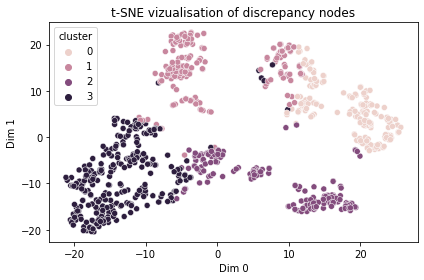

In [73]:
from sklearn.manifold import TSNE
try :
    del data["cluster"]
except KeyError:
    pass
tsne = TSNE(perplexity=50, n_jobs=-1).fit_transform(data)
tsne = pd.DataFrame(tsne, columns=["Dim 0", "Dim 1"])
tsne["cluster"] = clusters
sns.scatterplot(x="Dim 0", y="Dim 1", hue="cluster", data=tsne)
plt.title("t-SNE vizualisation of discrepancy nodes")
plt.tight_layout()
#plt.savefig("./../../results/discussion_tsne_boston.pdf")

### Observations 
#### Boston
- On a des clusters différents, des zones différentes de l'espace où le débiaisage se fait.
    - est-ce vraiment du au débiaisage? ou est-ce une zone d'incertitude que j'aurais eu sur des modèles différents quelconques? 
        - Est-ce une vraie question ?
        - En attendant: en comparant par rapport à l'autre notebook (mis dans le papier): certains clusters semblent semblables, d'autres non.
    - ce sont des zones où débiaiser à fait changer la prédiction
        - sans doute des variables corrélées donc?
        - ou bien, comme disait Vincent, celles qui dépendant causalement
    - 
    

# Next steps

- Use AIF360.... 
- 


ERROR: Could not find a version that satisfies the requirement libomp
ERROR: No matching distribution found for libomp


In [11]:
import sys
sys.path.append("../")
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_compas, load_preproc_data_german

from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()


dataset_orig = AdultDataset(protected_attribute_names=['race', 'sex'],
                 privileged_classes=[['White'], ['Male']],
                 categorical_features=[],#['workclass', 'education','marital-status', 'occupation', 'relationship', 'native-country'],
                 #features_to_drop=['fnlwgt'],
                features_to_keep=['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']) #load_preproc_data_adult()
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)


privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)


#### Training Dataset shape

(34189, 7)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['race', 'sex']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['age', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']


In [12]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.190870
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.203012


In [6]:
min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())

#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.198505
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.185202


In [7]:
sess = tf.Session()

plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False, sess=sess, num_epochs=10)


In [8]:
plain_model.fit(dataset_orig_train)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 0.672794
epoch 0; iter: 200; batch classifier loss: 0.526219
epoch 1; iter: 0; batch classifier loss: 0.413254
epoch 1; iter: 200; batch classifier loss: 0.420474
epoch 2; iter: 0; batch classifier loss: 0.359139
epoch 2; iter: 200; batch classifier loss: 0.368674
epoch 3; iter: 0; batch classifier loss: 0.414643
epoch 3; iter: 200; batch classifier loss: 0.368432
epoch 4; iter: 0; batch classifier loss: 0.343872
epoch 4; iter: 200; batch classifier loss: 0.403548
epoch 5; iter: 0; batch classifier loss: 0.451820
epoch 5; iter: 200; batch classifier loss: 0.419313
epoch 6; iter: 0; batch classifier loss: 0.428334
epoch 6; iter: 200; batch classifier loss: 0.397298
epoch 7; iter: 0; batch classifier loss: 0.376857
epoch 7; iter: 200; batch classifier loss: 0.321462
epoch 8; iter: 0; batch classifier loss: 0.380082
epoch 8; iter: 200; batch classifier loss: 0.400459
epoch 9; iter: 0; batch classifier loss: 0.306238
epoch 9; iter: 200; batch classi

In [9]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

In [10]:

# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.207171
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.206114


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.828909
Test set: Balanced classification accuracy = 0.710969
Test set: Disparate impact = 0.114568
Test set: Equal opportunity difference = -0.345371
Test set: Average odds difference = -0.221007
Test set: Theil_index = 0.148905


In [10]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Learn parameters with debias set to True
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)

In [11]:
debiased_model.fit(dataset_orig_train)

epoch 0; iter: 0; batch classifier loss: 0.691258; batch adversarial loss: 0.755124
epoch 0; iter: 200; batch classifier loss: 0.482546; batch adversarial loss: 0.718431
epoch 1; iter: 0; batch classifier loss: 0.454456; batch adversarial loss: 0.696670
epoch 1; iter: 200; batch classifier loss: 0.377524; batch adversarial loss: 0.650724
epoch 2; iter: 0; batch classifier loss: 0.504816; batch adversarial loss: 0.626104
epoch 2; iter: 200; batch classifier loss: 0.421572; batch adversarial loss: 0.608568
epoch 3; iter: 0; batch classifier loss: 0.409763; batch adversarial loss: 0.617464
epoch 3; iter: 200; batch classifier loss: 0.402537; batch adversarial loss: 0.602858
epoch 4; iter: 0; batch classifier loss: 0.346228; batch adversarial loss: 0.610729
epoch 4; iter: 200; batch classifier loss: 0.464465; batch adversarial loss: 0.643725
epoch 5; iter: 0; batch classifier loss: 0.403853; batch adversarial loss: 0.654964
epoch 5; iter: 200; batch classifier loss: 0.567213; batch adversa

epoch 48; iter: 200; batch classifier loss: 0.469139; batch adversarial loss: 0.619790
epoch 49; iter: 0; batch classifier loss: 0.365841; batch adversarial loss: 0.601287
epoch 49; iter: 200; batch classifier loss: 0.497392; batch adversarial loss: 0.581676


In [12]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

In [13]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())



display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.207394
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.210834


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.085854
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.086214


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.799973
Test set: Balanced classification accuracy = 0.656463
Test set: Disparate impact = 0.000000
Test set: Equal opportunity difference = -0.443967
Test set: Average odds difference = -0.275091
Test set: Theil_index = 0.183378


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.789053
Test set: Balanced classification accuracy = 0.667677
Test set: Disparate impact = 0.582567
Test set: Equal opportunity difference = -0.031110
Test set: Average odds difference = -0.024534
Test set: Theil_index = 0.175421


In [22]:
dataset_orig.features.shape

(48842, 18)

In [ ]:

generator = {'model': generative_model.DiscGen(n_touchpoints=len(model_pool),
                            n_features=X_train.shape[1],
                            n_hlayers=5,
                            n_hidden=50,
                            p_dropout=0.0)}
generator['optimizer'] = optim.Adam(generator['model'].parameters())
generator['loss_parameters'] = {
                    'k_align': 10.0,
                    'k_disc': 10.0}

N_EPOCHS_G = 40
generative_model.train_generator(generator, model_pool, train_loader, N_EPOCHS_G, plot=True)


In [ ]:
#X_test_disc
y_test_discr = []
a = 0
for x, _ in test_loader:
    pred = np.array([model['model'](x).detach().numpy() for model in model_pool]).reshape(2, -1)
    pred = (pred >= 0.5).astype('int').mean(axis=0)
    y_disc = ((pred < 1.0) * (pred > 0.0)).astype('int')
    y_test_discr.extend(y_disc)
    a += _.sum()
y_test_discr = torch.Tensor(y_test_discr).reshape(-1, 1)

discr_boys = X_test[torch.where(y_test_discr == 1)[0], :]
their_friends = generator['model'](torch.Tensor(discr_boys))

# comment analyser ça ? Est ce que le local est vriament ce qu'on veut ici ? 
# On sait quels TP sont pour quel modèle.

## Generative global

In [ ]:
########################
# Dans notebook
generator = {'model': generative_model_global.GlobalDiscGen(#n_touchpoints=len(model_pool),
                            n_features=X_train.shape[1],
                            n_hlayers=5,
                            n_hidden=50,
                            p_dropout=0.0)}
generator['optimizer'] = optim.Adam(generator['model'].parameters())
generator['loss_parameters'] = {
                    'k_align': 10.0,
                    'k_disc': 10.0}

N_EPOCHS_G = 40
generative_model_global.train_generator(generator, model_pool, train_loader, N_EPOCHS_G, plot=True)

In [ ]:
#evaluation

## sampling kde
## labellisation avec la pool; 1 si disc, 0 sinon
## on vérifie qu'on génère uniquement dans la zone disc.